In [ ]:
# !nvidia-smi

# Init

In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from keras.regularizers import l2

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [ ]:
# !python split.py

In [11]:
# Random seed for reproducibility
seed = 57

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#Dati
input_shape = (256, 256, 3)
epochs = 400

In [ ]:
dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
# test_dir = os.path.join(dataset_dir, 'test')

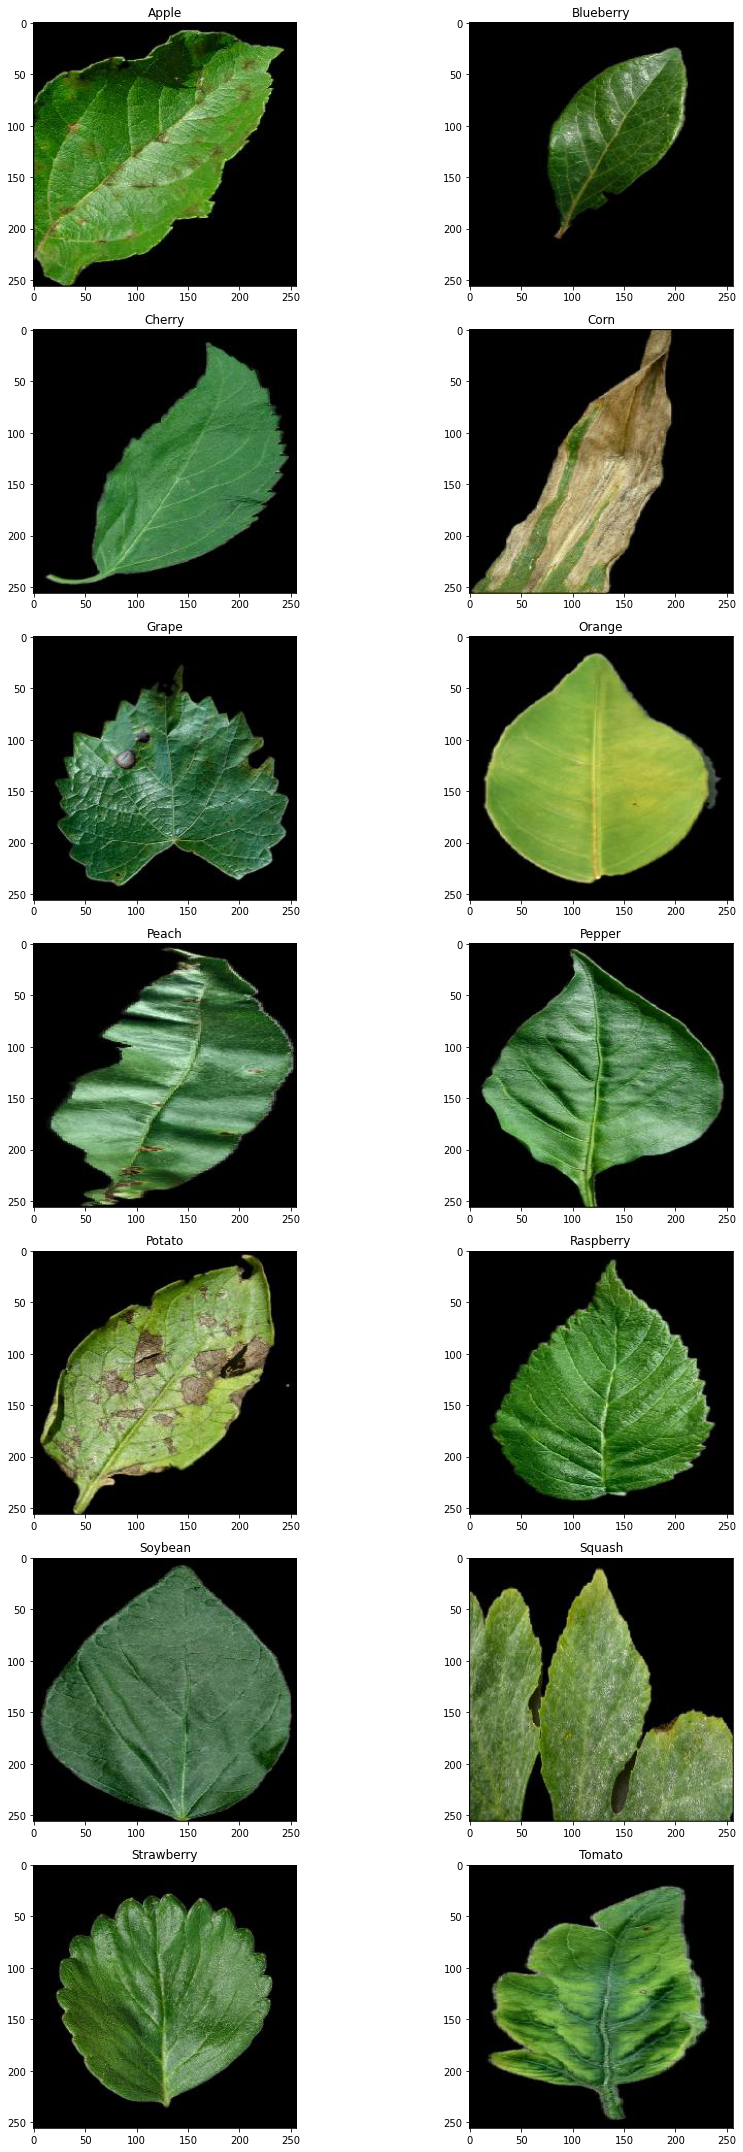

In [ ]:
# Plot example images from dataset
labels = ['Apple',
          'Blueberry',
          'Cherry',
          'Corn',
          'Grape',
          'Orange',
          'Peach',
          'Pepper',
          'Potato',
          'Raspberry',
          'Soybean',
          'Squash',
          'Strawberry',
          'Tomato'
          ]

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Import data

In [ ]:
#augmentation try

import Augmentor
from tensorflow.keras.applications.inception_v3 import preprocess_input

p = Augmentor.Pipeline()
p.set_seed(seed)

p.rotate(1, max_left_rotation=25, max_right_rotation=25)
p.rotate90(0.5)
p.rotate180(0.3)
p.rotate270(0.2)
p.flip_random(0.5)
p.random_distortion(0.3, 10, 10, 8)
p.skew(0.3)

def image_prep(img):
  funn = p.keras_preprocess_func()
  img = funn(img/255)
  img = np.array(img).astype('uint8')
  
  img = preprocess_input(img)
  
  return img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

aug_train_data_gen =  ImageDataGenerator(
                          rotation_range=180,
                          height_shift_range=0,
                          width_shift_range=0,
                          zoom_range=0.4,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='nearest',
                          preprocessing_function=preprocess_input
                          )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen =  aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                    target_size=(256,256),
                                                    color_mode = 'rgb',
                                                    class_mode='categorical',
                                                    batch_size = 16,
                                                    shuffle = True,
                                                    seed = seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                                    target_size=(256,256),
                                                    color_mode = 'rgb',
                                                    class_mode='categorical',
                                                    batch_size = 16,
                                                    shuffle = False,
                                                    seed = seed)

Found 11287 images belonging to 14 classes.
Found 1846 images belonging to 14 classes.


# Create the network

In [ ]:
# Import inception_v3 

from keras.applications.inception_v3 import InceptionV3

supernet = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
# supernet.summary()
# tfk.utils.plot_model(supernet)

In [ ]:
supernet.trainable = False
input_layer = tfkl.Input(shape=input_shape, name='Input')
x = supernet(input_layer)

avg = tfkl.GlobalAveragePooling2D()(x)
avg = tfkl.Dropout(0.4, seed=seed)(avg)
classifier_layer = tfkl.Dense(units=512, name='Classifier2', activation='relu')(avg)
classifier_layer = tfkl.Dropout(0.4, seed=seed)(classifier_layer)
output_layer = tfkl.Dense(units=14, activation='softmax', name='Output')(classifier_layer)

# Connect input and output through the Model class
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
opt = tfk.optimizers.Adam(0.00008)
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')

In [ ]:
# model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Classifier2 (Dense)          (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 14)                7182  

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

## Class weight to deal with unbalanced classes

In [ ]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.labels),
                                        y = aug_train_gen.labels                                                    
                                    )

print(class_weights)

minimum = 0
minimum = min(class_weights)

cv = {}
for i in range(14):
  cv[i] = class_weights[i]/minimum

print(cv)

[0.90687771 1.91955782 1.53857688 0.74305464 0.67184524 0.67184524
 0.91719486 1.17182309 1.25188554 3.40174804 0.67184524 1.56243079
 1.3325856  0.67184524]
{0: 1.3498312710911136, 1: 2.8571428571428568, 2: 2.2900763358778624, 3: 1.1059907834101383, 4: 1.0, 5: 1.0, 6: 1.3651877133105803, 7: 1.744186046511628, 8: 1.8633540372670807, 9: 5.063291139240506, 10: 1.0, 11: 2.3255813953488373, 12: 1.9834710743801653, 13: 1.0}


In [ ]:
#fit the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 251s 328ms/step - loss: 2.4107 - accuracy: 0.4713 - val_loss: 0.7890 - val_accuracy: 0.7784
Epoch 2/400
706/706 [==============================] - 221s 313ms/step - loss: 1.4090 - accuracy: 0.6885 - val_loss: 0.5192 - val_accuracy: 0.8564
Epoch 3/400
706/706 [==============================] - 220s 311ms/step - loss: 1.1183 - accuracy: 0.7485 - val_loss: 0.4244 - val_accuracy: 0.8694
Epoch 4/400
706/706 [==============================] - 219s 310ms/step - loss: 0.9682 - accuracy: 0.7870 - val_loss: 0.3671 - val_accuracy: 0.8895
Epoch 5/400
706/706 [==============================] - 221s 312ms/step - loss: 0.8839 - accuracy: 0.7999 - val_loss: 0.3324 - val_accuracy: 0.8982
Epoch 6/400
706/706 [==============================] - 222s 315ms/step - loss: 0.8112 - accuracy: 0.8188 - val_loss: 0.3426 - val_accuracy: 0.8954
Epoch 7/400
706/706 [==============================] - 222s 314ms/step - loss: 0.7535 - accuracy: 0.8320 - val_loss: 0

# Fine tuning

## Fine tuning mixed9

In [ ]:
###Fine tuning

# Set all Inception_v3 layers to True
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freeze first N layers, e.g., until the mixed9
for i, layer in enumerate(model.get_layer('inception_v3').layers[:276]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00007), metrics='accuracy')

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Fine-tune the model
ft_history = model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 228s 314ms/step - loss: 0.4560 - accuracy: 0.9016 - val_loss: 0.1484 - val_accuracy: 0.9523
Epoch 2/400
706/706 [==============================] - 221s 313ms/step - loss: 0.3176 - accuracy: 0.9281 - val_loss: 0.1375 - val_accuracy: 0.9550
Epoch 3/400
706/706 [==============================] - 221s 313ms/step - loss: 0.2574 - accuracy: 0.9391 - val_loss: 0.0788 - val_accuracy: 0.9740
Epoch 4/400
706/706 [==============================] - 222s 314ms/step - loss: 0.2291 - accuracy: 0.9471 - val_loss: 0.0817 - val_accuracy: 0.9713
Epoch 5/400
706/706 [==============================] - 221s 312ms/step - loss: 0.2160 - accuracy: 0.9527 - val_loss: 0.0792 - val_accuracy: 0.9756
Epoch 6/400
706/706 [==============================] - 221s 313ms/step - loss: 0.1869 - accuracy: 0.9570 - val_loss: 0.0794 - val_accuracy: 0.9729
Epoch 7/400
706/706 [==============================] - 221s 313ms/step - loss: 0.1872 - accuracy: 0.9584 - val_loss: 0

## Fine tuning mixed8

In [ ]:
###Fine tuning

# Set all Inception_v3 layers to True
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freeze first N layers, e.g., until the mixed8
for i, layer in enumerate(model.get_layer('inception_v3').layers[:248]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00006), metrics='accuracy')

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Fine-tune the model
ft_history = model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 234s 324ms/step - loss: 0.2305 - accuracy: 0.9483 - val_loss: 0.0764 - val_accuracy: 0.9745
Epoch 2/400
706/706 [==============================] - 227s 322ms/step - loss: 0.1702 - accuracy: 0.9617 - val_loss: 0.0633 - val_accuracy: 0.9783
Epoch 3/400
706/706 [==============================] - 227s 322ms/step - loss: 0.1523 - accuracy: 0.9657 - val_loss: 0.0550 - val_accuracy: 0.9783
Epoch 4/400
706/706 [==============================] - 228s 322ms/step - loss: 0.1239 - accuracy: 0.9703 - val_loss: 0.0493 - val_accuracy: 0.9854
Epoch 5/400
706/706 [==============================] - 228s 322ms/step - loss: 0.1237 - accuracy: 0.9719 - val_loss: 0.0400 - val_accuracy: 0.9875
Epoch 6/400
706/706 [==============================] - 227s 322ms/step - loss: 0.1120 - accuracy: 0.9755 - val_loss: 0.0422 - val_accuracy: 0.9854
Epoch 7/400
706/706 [==============================] - 227s 322ms/step - loss: 0.1062 - accuracy: 0.9764 - val_loss: 0

## Fine tuning mixed7

In [ ]:
###Fine tuning

# Set all Inception_v3 layers to True
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freeze first N layers, e.g., until the mixed7
for i, layer in enumerate(model.get_layer('inception_v3').layers[:228]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00006), metrics='accuracy')

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Fine-tune the model
ft_history = model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 239s 330ms/step - loss: 0.0919 - accuracy: 0.9790 - val_loss: 0.0560 - val_accuracy: 0.9789
Epoch 2/400
706/706 [==============================] - 232s 328ms/step - loss: 0.0782 - accuracy: 0.9799 - val_loss: 0.0365 - val_accuracy: 0.9881
Epoch 3/400
706/706 [==============================] - 232s 328ms/step - loss: 0.0730 - accuracy: 0.9846 - val_loss: 0.0488 - val_accuracy: 0.9892
Epoch 4/400
706/706 [==============================] - 232s 328ms/step - loss: 0.0814 - accuracy: 0.9828 - val_loss: 0.0251 - val_accuracy: 0.9908
Epoch 5/400
706/706 [==============================] - 232s 328ms/step - loss: 0.0759 - accuracy: 0.9846 - val_loss: 0.0178 - val_accuracy: 0.9919
Epoch 6/400
706/706 [==============================] - 232s 328ms/step - loss: 0.0593 - accuracy: 0.9856 - val_loss: 0.0226 - val_accuracy: 0.9935
Epoch 7/400
706/706 [==============================] - 232s 328ms/step - loss: 0.0650 - accuracy: 0.9826 - val_loss: 0

## Fine tuning mixed6

In [ ]:
###Fine tuning

# Set all Inception_v3 layers to True
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freeze first N layers, e.g., until the mixed6
for i, layer in enumerate(model.get_layer('inception_v3').layers[:196]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00005), metrics='accuracy')

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Fine-tune the model
ft_history = model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 246s 340ms/step - loss: 0.0820 - accuracy: 0.9830 - val_loss: 0.0334 - val_accuracy: 0.9908
Epoch 2/400
706/706 [==============================] - 240s 339ms/step - loss: 0.0841 - accuracy: 0.9825 - val_loss: 0.0285 - val_accuracy: 0.9902
Epoch 3/400
706/706 [==============================] - 239s 339ms/step - loss: 0.0632 - accuracy: 0.9868 - val_loss: 0.0161 - val_accuracy: 0.9935
Epoch 4/400
706/706 [==============================] - 239s 338ms/step - loss: 0.0518 - accuracy: 0.9873 - val_loss: 0.0210 - val_accuracy: 0.9924
Epoch 5/400
706/706 [==============================] - 238s 337ms/step - loss: 0.0628 - accuracy: 0.9868 - val_loss: 0.0163 - val_accuracy: 0.9935
Epoch 6/400
706/706 [==============================] - 239s 338ms/step - loss: 0.0527 - accuracy: 0.9884 - val_loss: 0.0143 - val_accuracy: 0.9930
Epoch 7/400
706/706 [==============================] - 239s 339ms/step - loss: 0.0498 - accuracy: 0.9895 - val_loss: 0

## Fine tuning mixed5

In [ ]:
###Fine tuning

# Set all Inception_v3 layers to True
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freeze first N layers, e.g., until the mixed5
for i, layer in enumerate(model.get_layer('inception_v3').layers[:164]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00004), metrics='accuracy')

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Fine-tune the model
ft_history = model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 254s 351ms/step - loss: 0.0572 - accuracy: 0.9897 - val_loss: 0.0157 - val_accuracy: 0.9957
Epoch 2/400
706/706 [==============================] - 247s 350ms/step - loss: 0.0505 - accuracy: 0.9893 - val_loss: 0.0340 - val_accuracy: 0.9919
Epoch 3/400
706/706 [==============================] - 247s 350ms/step - loss: 0.0344 - accuracy: 0.9923 - val_loss: 0.0121 - val_accuracy: 0.9962
Epoch 4/400
706/706 [==============================] - 246s 348ms/step - loss: 0.0465 - accuracy: 0.9896 - val_loss: 0.0118 - val_accuracy: 0.9962
Epoch 5/400
706/706 [==============================] - 246s 348ms/step - loss: 0.0360 - accuracy: 0.9925 - val_loss: 0.0115 - val_accuracy: 0.9962
Epoch 6/400
706/706 [==============================] - 246s 348ms/step - loss: 0.0385 - accuracy: 0.9918 - val_loss: 0.0148 - val_accuracy: 0.9957
Epoch 7/400
706/706 [==============================] - 246s 348ms/step - loss: 0.0412 - accuracy: 0.9915 - val_loss: 0

In [ ]:
#save the model for the comparison
model.save('ModelloFinaleM5.h5')

INFO:tensorflow:Assets written to: ModelloFinaleM5/assets


INFO:tensorflow:Assets written to: ModelloFinaleM5/assets


## Fine tuning mixed 4

In [ ]:
###Fine tuning

# Set all Inception_v3 layers to True
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freeze first N layers, e.g., until the mixed4
for i, layer in enumerate(model.get_layer('inception_v3').layers[:132]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00003), metrics='accuracy')

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Fine-tune the model
ft_history = model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 264s 365ms/step - loss: 0.0410 - accuracy: 0.9902 - val_loss: 0.0085 - val_accuracy: 0.9957
Epoch 2/400
706/706 [==============================] - 255s 361ms/step - loss: 0.0376 - accuracy: 0.9910 - val_loss: 0.0245 - val_accuracy: 0.9913
Epoch 3/400
706/706 [==============================] - 255s 361ms/step - loss: 0.0289 - accuracy: 0.9936 - val_loss: 0.0105 - val_accuracy: 0.9946
Epoch 4/400
706/706 [==============================] - 254s 360ms/step - loss: 0.0353 - accuracy: 0.9930 - val_loss: 0.0165 - val_accuracy: 0.9957
Epoch 5/400
706/706 [==============================] - 255s 361ms/step - loss: 0.0354 - accuracy: 0.9917 - val_loss: 0.0105 - val_accuracy: 0.9984
Epoch 6/400
706/706 [==============================] - 255s 361ms/step - loss: 0.0351 - accuracy: 0.9930 - val_loss: 0.0039 - val_accuracy: 0.9973
Epoch 7/400
706/706 [==============================] - 255s 361ms/step - loss: 0.0242 - accuracy: 0.9948 - val_loss: 0

In [ ]:
#save the model for the comparison
model.save('ModelloFinaleM4.h5')

INFO:tensorflow:Assets written to: ModelloFinaleM4/assets


INFO:tensorflow:Assets written to: ModelloFinaleM4/assets


## Fine tuning mixed3

In [ ]:
###Fine tuning

# Set all Inception_v3 layers to True
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [ ]:
# Freeze first N layers, e.g., until the mixed3
for i, layer in enumerate(model.get_layer('inception_v3').layers[:100]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00002), metrics='accuracy')

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Fine-tune the model
ft_history = model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[early_stopping],
    class_weight=cv
).history

Epoch 1/400
706/706 [==============================] - 269s 371ms/step - loss: 0.0278 - accuracy: 0.9934 - val_loss: 0.0068 - val_accuracy: 0.9973
Epoch 2/400
706/706 [==============================] - 261s 370ms/step - loss: 0.0366 - accuracy: 0.9932 - val_loss: 0.0075 - val_accuracy: 0.9973
Epoch 3/400
706/706 [==============================] - 261s 370ms/step - loss: 0.0227 - accuracy: 0.9939 - val_loss: 0.0047 - val_accuracy: 0.9973
Epoch 4/400
706/706 [==============================] - 260s 368ms/step - loss: 0.0178 - accuracy: 0.9956 - val_loss: 0.0034 - val_accuracy: 0.9989
Epoch 5/400
706/706 [==============================] - 260s 368ms/step - loss: 0.0182 - accuracy: 0.9961 - val_loss: 0.0051 - val_accuracy: 0.9973
Epoch 6/400
706/706 [==============================] - 260s 368ms/step - loss: 0.0244 - accuracy: 0.9943 - val_loss: 0.0091 - val_accuracy: 0.9967
Epoch 7/400
706/706 [==============================] - 260s 367ms/step - loss: 0.0199 - accuracy: 0.9952 - val_loss: 0

In [ ]:
#save the model for the comparison
model.save('ModelloFinaleM3.h5')

INFO:tensorflow:Assets written to: ModelloFinaleM3/assets


INFO:tensorflow:Assets written to: ModelloFinaleM3/assets


# Test

In [12]:
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_data_generator.flow_from_directory(
    directory="test/", # the directory
    target_size=(256,256), # the size I want for the images (it resize the images to that one) - we use the original one
    color_mode='rgb', # use the tree channels for the colors
    classes=None, # default is None (this allows to decide from the name of the classes which is the integer to be associated to this class)
                  #   with None, it will read the folder name, and order it in lexicographical order
                  #   classes=lables    ## will give the integer associated to the classes as lable!
    batch_size=14,
    shuffle=False, # to shuffle the data at the end of every epoch 
    seed=seed
)

Found 5426 images belonging to 14 classes.


In [14]:
model = tf.keras.models.load_model('ModelloFinaleM5.h5')

In [15]:
model_noaug_test_metrics = model.evaluate(test_gen, return_dict=True)
print()
print("Test metrics")
print(model_noaug_test_metrics)

388/388 [==============================] - 62s 118ms/step - loss: 0.1739 - accuracy: 0.9512

Test metrics
{'loss': 0.17390327155590057, 'accuracy': 0.9511610865592957}


In [16]:
model = tf.keras.models.load_model('ModelloFinaleM4.h5')

In [17]:
model_noaug_test_metrics = model.evaluate(test_gen, return_dict=True)
print()
print("Test metrics")
print(model_noaug_test_metrics)

388/388 [==============================] - 46s 115ms/step - loss: 0.0802 - accuracy: 0.9760

Test metrics
{'loss': 0.08017964661121368, 'accuracy': 0.9760412573814392}


In [18]:
model = tf.keras.models.load_model('ModelloFinaleM3.h5')

In [19]:
model_noaug_test_metrics = model.evaluate(test_gen, return_dict=True)
print()
print("Test metrics")
print(model_noaug_test_metrics)

388/388 [==============================] - 46s 116ms/step - loss: 0.1383 - accuracy: 0.9595

Test metrics
{'loss': 0.13833346962928772, 'accuracy': 0.9594544768333435}


# Network shape

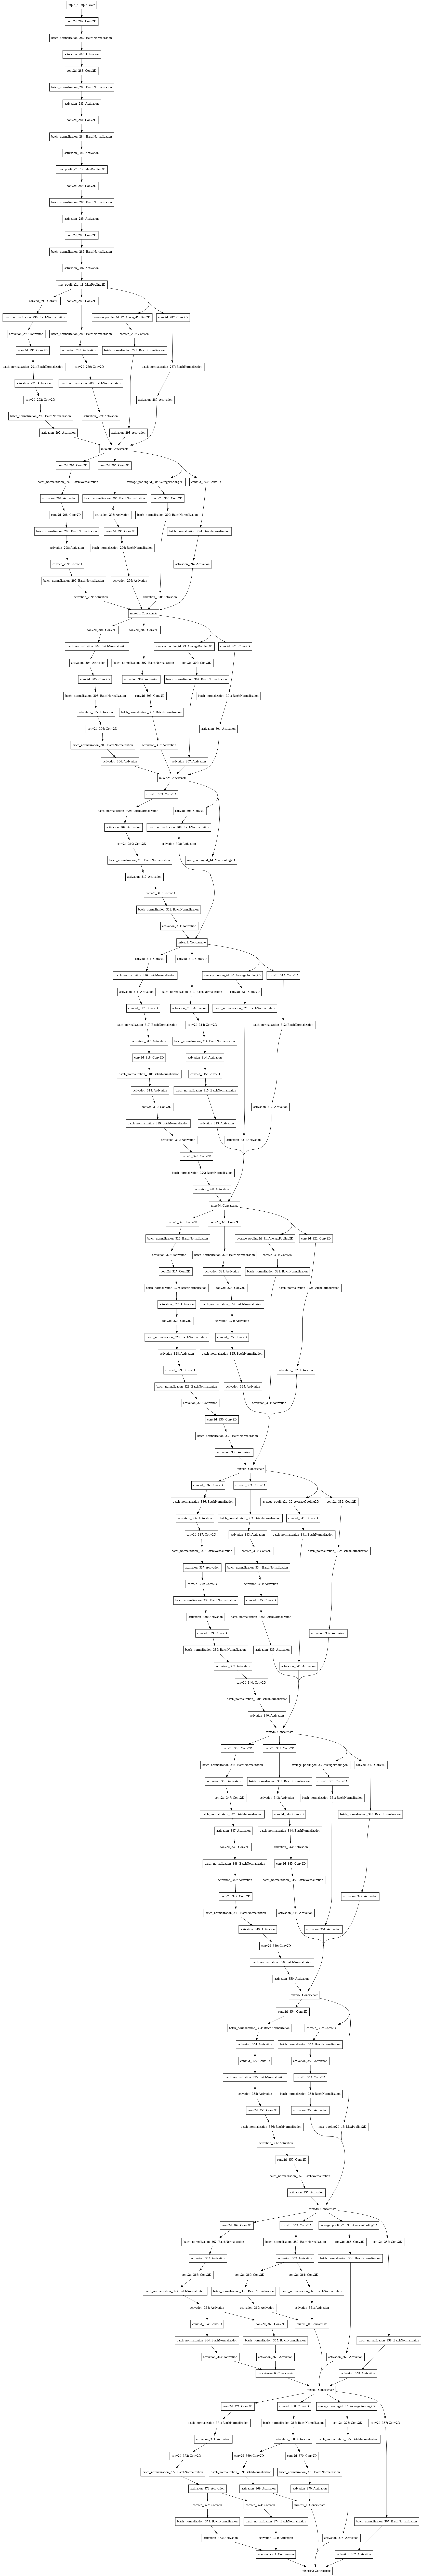

In [ ]:
tfk.utils.plot_model(supernet)